# (Kaggle) Store Sales - Time Series Forecasting

In [1]:
import datetime
import os
import random
from collections.abc import Iterable
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
import plotly.io
import plotly.offline
import plotly.subplots
import polars as pl
import polars.selectors as cs
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

random.seed(3)
tf.random.set_seed(3)

tf.config.list_physical_devices()

2024-05-10 15:34:36.962089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.15.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
plotly.offline.init_notebook_mode(connected=True)
plotly.io.renderers.default = "notebook_connected"
# plotly.io.templates.default = "plotly_dark"

In [3]:
# TODO Write the notes in Markdown

# TODO Test models without x-window metadata
# TODO Fix definition of CONV model and test
# TODO Increase TIMESTEPS and train larger models with longer inputs (-> add 128)

# TODO After evaluation: retrain the models for a few steps with the validation data
# TODO Predict the worst keys differently?

In [4]:
INPUT_DIR = os.path.abspath("input")  # directory with inputs from the competition


TARGET_LENGTH = 16  # length of the target sequences

# metadata columns = [items on promotion, oil prices, weekday]
METADATA_COLS = ["onpromotion", "dcoilwtico", "weekday"]
FEATURES = 1 + len(METADATA_COLS)  # number of input features

TIMESTEPS = 800  # number of timesteps to use in training


# training hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

# the Kaggle competition uses Root Mean Squared Logarithmic Error
LOSS = tf.keras.losses.MeanSquaredLogarithmicError()

# DATA EXPLORATION

In [5]:
train_df = pl.read_csv(os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True)

# aggregate the training data into two time series for 'sales' and 'onpromotion'
train_df = (
    train_df.group_by("date")
    .agg(pl.col("sales").sum(), pl.col("onpromotion").sum())
    .sort(by="date")
)

px.line(train_df, x="date", y="sales", height=400, title="total sales")

In [6]:
# make a dataframe containing the DFT of the 'sales' column
dft_df = pl.DataFrame(
    {"DFT": tf.abs(tf.signal.rfft(train_df["sales"])).numpy()}
).with_row_index(name="frequency")

# drop frequencies corresponding to periods greater than one year
dft_df = dft_df.tail(-int(len(train_df) / 365.25))

# make xticks at frequencies freq = num_samples/period for selected periods
xticks = [365.25, 93, 30.5, 15, 7, 3.5]

fig = px.line(dft_df, x="frequency", y="DFT")
fig.update_xaxes(
    type="log",
    tickmode="array",
    tickvals=[len(train_df) / x for x in xticks],
    ticktext=[str(x) for x in xticks],
    title="inverse frequency",
)
fig.update_layout(height=400, title="DFT of total sales")
fig.show()

In [7]:
# NOTE We see a significant 7-days periodicity in the sales values.
# NOTE We plot this prediodicity (as well as the less significant 3.5-days one)
# NOTE on a bar plot where the higher sales volume on the weekend (days 6 and 7)
# NOTE is very apparent.

# add a weekday signal to the dataframe
train_df = train_df.with_columns(pl.col("date").dt.weekday().alias("weekday"))

# plot the average sales by day of the week
fig = px.bar(
    train_df.group_by("weekday").mean().sort(by="weekday"), x="weekday", y="sales"
)
fig.update_layout(height=400)
fig.show()

In [8]:
# NOTE We now compute the correlation between our 'metadata' columns, i.e.
# NOTE the 'weekday' column, the 'onpromotion' columns and the oil prices.

# read the oil prices and add them to the training data
oil_df = (
    pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
    .interpolate()
    .fill_null(strategy="backward")
)
train_df = train_df.join(oil_df, on="date", how="inner")

print(train_df.drop("date").corr()[0])

# NOTE We see significant correlation between the sales and both
# NOTE the number of items on promotion ('onpromotion' column)
# NOTE and the oil price ('dcoilwtico' column), as well as a
# NOTE mild correlation with the weekday.

shape: (1, 4)
┌───────┬─────────────┬───────────┬────────────┐
│ sales ┆ onpromotion ┆ weekday   ┆ dcoilwtico │
│ ---   ┆ ---         ┆ ---       ┆ ---        │
│ f64   ┆ f64         ┆ f64       ┆ f64        │
╞═══════╪═════════════╪═══════════╪════════════╡
│ 1.0   ┆ 0.71735     ┆ -0.100565 ┆ -0.690145  │
└───────┴─────────────┴───────────┴────────────┘


# DATA PREPARATION

In [9]:
def fill_missing_dates(df: pl.DataFrame) -> pl.DataFrame:
    """Adds the missing dates and fills the missing values."""

    date_df = pl.DataFrame(
        pl.date_range(
            df["date"].min(), df["date"].max(), interval="1d", eager=True
        ).alias("date")
    )

    df = date_df.join(
        df,
        on="date",
        how="outer",
    ).drop("date_right")

    # interpolate and fill backward/forward in case the first/last value is missing
    df = df.interpolate().fill_null(strategy="backward").fill_null(strategy="forward")

    return df

In [10]:
# NOTE Prepare the data by splitting the training dataframe into one dataframes for
# NOTE each (store_nbr, family) pair (= a 'key').
#
# NOTE Further split the last TARGET_LENGTH timesteps from each dataframe to use
# NOTE as test set to evaluate the models.

In [11]:
def read_dataframes(
    timesteps: int,
) -> tuple[dict[tuple[int, str], pl.DataFrame], dict[tuple[int, str], pl.DataFrame]]:
    # read and complete the dataframe containing the oil prices
    oil_df = pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
    oil_df = fill_missing_dates(oil_df)

    train_df = pl.read_csv(os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True)
    train_df = train_df.drop("id")  # we do not need the id

    # keep only the chosen number of timesteps plus TARGET_LENGTH steps to use as test set
    train_df = train_df.filter(
        pl.col("date")
        > train_df["date"].max() - datetime.timedelta(timesteps + TARGET_LENGTH)
    )

    # partition the training data into dataframes for each (store_nbr, family) pair
    dataframes = train_df.partition_by(
        ["store_nbr", "family"], include_key=False, as_dict=True
    )

    # fill missing dates and add oil prices and weekday signal to each dataframe
    for key, df in dataframes.items():
        dataframes[key] = (
            fill_missing_dates(df)
            .join(oil_df, on="date", how="inner")
            .with_columns(pl.col("date").dt.weekday().alias("weekday"))
            .with_columns(cs.numeric().cast(pl.Float32))
        )

    # split the last TARGET_LENGTH timesteps of each dataframe to use as test set
    test_dataframes = {key: df.tail(TARGET_LENGTH) for key, df in dataframes.items()}
    dataframes = {key: df.head(-TARGET_LENGTH) for key, df in dataframes.items()}

    return dataframes, test_dataframes

In [12]:
dataframes, test_dataframes = read_dataframes(TIMESTEPS)

key = next(iter(dataframes.keys()))
print("columns:", dataframes[key].columns)
print("training dataframes shape:", dataframes[key].shape)
print("test dataframes shape    :", test_dataframes[key].shape)

columns: ['date', 'sales', 'onpromotion', 'dcoilwtico', 'weekday']
training dataframes shape: (800, 5)
test dataframes shape    : (16, 5)


In [13]:
# plot sample series
sample_df = pl.concat(
    [
        dataframes[key].select("sales").rename(lambda _: str(key))
        for key in random.sample(list(dataframes.keys()), 5)
    ],
    how="horizontal",
)

sample_df = sample_df.with_columns(
    (pl.all() - pl.all().mean()) / (pl.all().std() + 1e-3)
)

px.line(sample_df)

# STRATEGY AND MODEL BLUEPRINT

## General model architecture

In [14]:
# NOTE Notation:
# NOTE - S = sales
# NOTE - M = (M_1, M_2, ...) = vector of metadata variables
# NOTE - Z(t) = value of variable Z at timestep t

# NOTE Ansatz: there exists a random variable X which underlies S
# NOTE in the sense that S = f(X, M) for some function f.

# NOTE We consider windows (sequences of consecutive timesteps) composed of N+T timesteps
# NOTE and split into two parts
# NOTE (t_(-N-1), ..., t_0) of N = input_length timesteps   ->  x-window (xW)
# NOTE (t_1, ..., t_T)      of T = TARGET_LENGTH timesteps  ->  y-window (yW)
#
# NOTE We have the values of all metadata variables on the entire window and the values of S on the x-window.
# NOTE We want to predict the values of S on the y-window.

# NOTE We proceed in three steps:
# NOTE 1. DECOUPLING: extract the value of the underlying variable X on the x-window from those of S and M
# NOTE   {S(t), M(t) : t in xW} -> {X(t) : t in xW}
# NOTE 2. TIME SERIES PREDICTION: predict the values of X on the y-window from its values on the x-window
# NOTE   {X(t) : t in xW} -> {X(t) : t in yW}
# NOTE 3. COUPLING: combine X with the metadata to obtain the values of S on the y-window
# NOTE   {X(t), M(t) : t in yW} -> {S(t) : t in yW}
# NOTE Each arrow represents a neural network and takes the values of the previous network as input.
#
# NOTE The process can be summarized as:
# NOTE [S(xW), M(xW)] -> |DECOUPNET| -> X(xW) -> |TIMENET| -> X(yW) -> [X(yW), M(yW)] -> |COUPNET| -> S(yW)

# NOTE We will use dense models to do the coupling/decoupling and try different architectures for the TS prediction.

In [15]:
# NOTE Create decoupling/coupling networks to use in all models.
# NOTE We choose simple architectures under the assumption that the coupling relation
# NOTE (the function f above) is not very complicated.

decoupling_net = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, FEATURES)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
    ],
    name="DecoupNet",
)

# NOTE Initializing the kernel of the last layers with ones avoids the model
# NOTE getting stuck and not learning, which can happen if the kernel weights
# NOTE are too close to zero. In that case, the outputs are close to zero
# NOTE and the model cannot take large enough steps to learn.
# NOTE This sometimes happens with the default initializer 'glorot_uniform'
# NOTE (and happens every time if we initialize with 'zeros').

coupling_net = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(TARGET_LENGTH, FEATURES)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, kernel_initializer="ones"),
    ],
    name="CoupNet",
)

In [16]:
def make_model(timenet: tf.keras.Model, name: str) -> tf.keras.Model:
    # create instances of the decoupling/coupling networks to use in the model
    dcnet = tf.keras.models.clone_model(decoupling_net)
    cnet = tf.keras.models.clone_model(coupling_net)

    # variable names are in the form `window_var`
    x_win = tf.keras.Input(shape=(None, FEATURES), name="x-window")
    y_m = tf.keras.Input(shape=(TARGET_LENGTH, FEATURES - 1), name="y-metadata")

    x_x = dcnet(x_win)
    y_x = timenet(x_x)
    y_xm = tf.keras.layers.Concatenate(axis=-1, name="y-concat")([y_x, y_m])
    y_s = cnet(y_xm)

    model = tf.keras.Model(inputs=[x_win, y_m], outputs=y_s, name=name)

    model.compile(
        loss=LOSS, optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    )

    return model

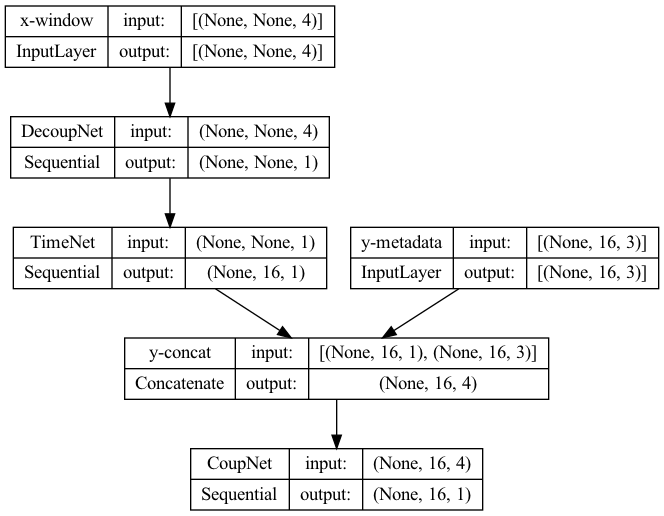

In [17]:
# make a dummy TimeNet to illustrate the architecture
dummy_timenet = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, 1)),
        tf.keras.layers.Lambda(lambda xs: xs[-TARGET_LENGTH:]),
        tf.keras.layers.Reshape((TARGET_LENGTH, 1)),
    ],
    name="TimeNet",
)

dummy_model = make_model(dummy_timenet, name="dummy")

tf.keras.utils.plot_model(dummy_model, show_shapes=True, to_file="blueprint.png")

## Dataset creation

In [18]:
# NOTE A window is window_length = input_length + TARGET_LENGTH timesteps of consecutive data from a dataframe.
# NOTE Each window produces one (input, target) pair, where
# NOTE - target = y-window metadata
# NOTE - input = (x-window, y-window metadata)

# NOTE For a single key, the number of windows is window_count = TIMESTEPS - window_length + 1.
# NOTE The total number of elements in the dataset is thus ceil(window_count * len(keys) / BATCH_SIZE).

# NOTE Having `batch` before `map` gives a marginal performance increase
# NOTE see https://www.tensorflow.org/guide/data_performance
# NOTE verified in practice

In [19]:
class KeysDataset(tf.data.Dataset):
    @tf.function
    def _split_batch_window(window: tf.Tensor):
        # split window into x-window and y-window - keep the batches
        x_win = window[:, :-TARGET_LENGTH]
        y_win = window[:, -TARGET_LENGTH:]

        y_s = tf.gather(y_win, indices=[0], axis=-1)
        y_m = tf.gather(y_win, indices=[1, 2, 3], axis=-1)

        return (x_win, y_m), y_s

    def _generator(window_length: int, window_count: int, xs: tf.Tensor):
        for key_ind in range(xs.shape[0]):
            for window_ind in range(window_count):
                yield xs[key_ind, window_ind : window_ind + window_length]

    def __new__(
        cls, input_length: int, keys: Iterable[tuple[int, str]], steps: int, train: bool
    ) -> tf.data.Dataset:
        dfs = [dataframes[key].select(["sales"] + METADATA_COLS) for key in keys]

        if train:
            dfs = [df.head(steps) for df in dfs]
        else:
            dfs = [df.tail(steps) for df in dfs]

        window_length = input_length + TARGET_LENGTH
        window_count = len(dfs[0]) - window_length + 1
        window_spec = tf.TensorSpec(shape=(window_length, FEATURES), dtype=tf.float32)

        # stack all data into one tensor -> (keys, timesteps, features)
        # xs = tf.concat([tf.expand_dims(df, 0) for df in dfs], axis=0)
        xs = tf.stack([tf.constant(df) for df in dfs], axis=0)

        ds = tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=window_spec,
            args=(window_length, window_count, xs),
        )

        ds = (
            ds.batch(BATCH_SIZE)
            .map(cls._split_batch_window, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
        )

        return ds

In [20]:
# NOTE Note on the train/valid split of the KeysDatasets
#
# NOTE Because of how the windowing works, if we split the dataframes into
# NOTE train/valid dataframes with the selected training ratio, the resulting
# NOTE datasets can be split very differently.
# NOTE The number of windows in a dataset of length T is T - window_length + 1,
# NOTE so if we were to start with 600 timesteps and split them with 0.8 train ratio
# NOTE we would get 480/120 train/valid timestes. If the input length is 96,
# NOTE the number of train/valid windows (for a single key) is 369/9,
# NOTE which is a 41/1 split.
#
# NOTE For this reason, we do not split the dataframe directly using the ratio
# NOTE but instead compute the number of train/valid timesteps needed
# NOTE so that the split of train/valid windows matches the chosen ratio.

In [21]:
# NOTE The number of windows available with T timesteps is T - window_length + 1.


class KeysDatasets:
    def __init__(
        self,
        input_length: int,
        keys: Iterable[tuple[int, str]],
        train_ratio: float = 0.8,
    ):
        window_length = input_length + TARGET_LENGTH
        total_windows = TIMESTEPS - 2 * window_length + 2  # train + valid windows

        train_windows = int(total_windows * train_ratio)
        valid_windows = total_windows - train_windows

        train_timesteps = train_windows + window_length - 1
        valid_timesteps = valid_windows + window_length - 1

        # make training and validation datasets
        self.train = KeysDataset(input_length, keys, train_timesteps, train=True)
        self.valid = KeysDataset(input_length, keys, valid_timesteps, train=False)

        # compute the number of batches in each dataset
        self.train_batches = ceil(train_windows * len(keys) / BATCH_SIZE)
        self.valid_batches = ceil(valid_windows * len(keys) / BATCH_SIZE)

    @property
    def length(self) -> dict[str, int]:
        return {"train": self.train_batches, "valid": self.valid_batches}

## Training loop

In [22]:
# NOTE The train datasets obtained by taking all the key are
# NOTE fairly large (between 8.5k and 10k batches).
#
# NOTE To smoothen the training process, we split each epoch
# NOTE (one pass through the entire train dataset) into epoch_split parts.
# NOTE This gives epoch * epoch_split split epochs, which is the number of
# NOTE epochs that we pass to `model.fit()`.
# NOTE Each split epoch trains on ds.length['train'] // epoch_split batches.
# NOTE We need `ds.train.repeat()` in `model.fit()` to be able to loop over
# NOTE the (full) training dataset more than once.
#
# NOTE This is (up to rounding) equivalent to training for `epoch` epochs
# NOTE without splitting the dataset. However, doing so makes for very large epochs
# NOTE (~10k batches), which makes the saving and evaluating happen less often.
#
# NOTE The valid dataset is not split, so the validation loss does reflect the
# NOTE model's progress over time, but the training loss might not.

In [23]:
# NOTE Monitor training via TensorBoard by running
# NOTE tensorboard --logdir log/tensorboard

In [24]:
def train(
    model: tf.keras.Model,
    ds: KeysDatasets,
    epochs: int,
    epoch_split: int,
    selection: bool = False,
):
    split_epochs = epochs * epoch_split  # number of epochs to pass to model.fit()
    steps_per_epoch = ds.length["train"] // epoch_split  # steps per split epoch

    history_dir = "selection" if selection else "history"

    csv_logger = tf.keras.callbacks.CSVLogger(
        filename=os.path.join("log", history_dir, f"{model.name}.csv"), append=False
    )

    callbacks = [csv_logger]

    if not selection:
        os.makedirs(os.path.join("models"), exist_ok=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join("models", f"{model.name}.keras")
        )

        # # NOTE save weights if trainig on Kaggle because of issues loading the full model
        # os.makedirs(os.path.join("models", "weights", model.name), exist_ok=True)
        # wt_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        #     filepath=os.path.join(
        #         "models", "weights", model.name, model.name + "-{epoch:03d}.weights.h5"
        #     ),
        #     save_weights_only=True,
        # )

        os.makedirs(os.path.join("log", "tensorboard", model.name), exist_ok=True)
        tb_logger = tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join("log", "tensorboard", model.name)
        )

        # train for at least half the epochs before possibly stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, start_from_epoch=(split_epochs // 2)
        )

        callbacks += [checkpoint, tb_logger, early_stopping]

    _ = model.fit(
        ds.train.repeat(),
        validation_data=ds.valid,
        epochs=split_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
    )

# MODEL SELECTION

In [25]:
# make a folder to store the training logs of the selection process
os.makedirs(os.path.join("log", "selection"), exist_ok=True)

In [26]:
# NOTE During the selection phase, we train the models on a small sample of keys only
# NOTE in order to speed up the process.

SELECT_EPOCHS = 5
SELECT_EPOCH_SPLIT = 4

KEY_SAMPLE_RATIO = 0.1  # ratio of keys to use during selection

# we will test several input lengths
INPUT_LENGTHS = (32, 64, 96, 128)

# sample keys to use during the selection phase
key_sample = random.sample(
    list(dataframes.keys()), int(len(dataframes) * KEY_SAMPLE_RATIO)
)

# make a pair of (train, valid) datasets for each input length
kds = {
    input_length: KeysDatasets(input_length, key_sample)
    for input_length in INPUT_LENGTHS
}

In [27]:
def plot_selection_metric(model_root_name: str, metric: str = "val_loss") -> go.Figure:
    logs = {
        os.path.splitext(file)[0]: os.path.join("log", "selection", file)
        for file in sorted(os.listdir(os.path.join("log", "selection")))
        if file.split("-")[0] == model_root_name
    }

    metric_df = pl.concat(
        [
            pl.read_csv(log).select(metric).rename(lambda _: name)
            for name, log in logs.items()
        ],
        how="horizontal",
    ).with_row_index("epoch")

    plot = px.line(
        data_frame=metric_df,
        x="epoch",
        y=list(logs.keys()),
        log_y=True,
        title=f"logarithmic {metric} of {model_root_name} models",
        markers=True,
    )

    return plot

## Dense models

In [28]:
def make_dense_model(depth: int, width: int, input_length: int = 64) -> tf.keras.Model:
    name = f"DENS-{depth}{width}x{input_length}"

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(input_length, 1)))

    for _ in range(depth):
        timenet.add(tf.keras.layers.Dense(units=width, activation="relu"))

    timenet.add(tf.keras.layers.Flatten())
    timenet.add(tf.keras.layers.Dense(TARGET_LENGTH))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

In [29]:
%%script echo skipping

DENS_ARCHS = [(1, 16), (2, 16), (2, 32), (3, 16)]

for arch in DENS_ARCHS:
    model = make_dense_model(*arch, input_length=32)

    train(
        model,
        kds[32],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

skipping


In [30]:
plot_selection_metric("DENS")

## Convolutional models

In [31]:
%%script echo skipping

# TODO fix architecture to allow for wider models 


def make_conv_model(arch: Iterable[int], filters: int = 16) -> tf.keras.Model:
    name = "CONV-" + "".join(str(x) for x in arch)

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(None, 1)))

    for ks in arch:
        timenet.add(tf.keras.layers.Conv1D(16, kernel_size=ks, activation="relu"))

    timenet.add(tf.keras.layers.Lambda(lambda xs: xs[:, -1, :]))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

skipping


## LSTM models

In [32]:
def make_lstm_model(depth: int, width: int) -> tf.keras.Model:
    name = f"LSTM-{depth}{width}"

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(None, 1)))

    for _ in range(depth):
        timenet.add(tf.keras.layers.LSTM(width, return_sequences=True))

    timenet.add(tf.keras.layers.LSTM(TARGET_LENGTH, return_sequences=False))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

In [33]:
%%script echo skipping

LSTM_ARCHS = [(2, 16), (4, 16), (2, 32), (4, 32)]

for arch in LSTM_ARCHS:
    model = make_lstm_model(*arch)

    train(
        model,
        kds[32],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

skipping


In [34]:
plot_selection_metric("LSTM")

## Comparison of input lengths

In [35]:
%%script echo skipping

# train a dense model for each input length
for input_length in INPUT_LENGTHS:
    model = make_dense_model(*(3, 16), input_length=input_length)
    model._name = 'il_' + model.name

    train(
        model,
        kds[input_length],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

il_lstm_models = dict()

# train a LSTM model for each input length
for input_length in INPUT_LENGTHS:
    model = make_lstm_model(2, 16)
    model._name = "il_" + model.name + "x" + str(input_length)

    train(
        model,
        kds[input_length],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

    il_lstm_models[input_length] = model  # store the model for evaluation

skipping


In [36]:
idens_df = pl.concat(
    [
        pl.read_csv(os.path.join("log", "selection", f"il_DENS-316x{input_length}.csv"))
        .drop(["epoch", "loss"])
        .rename(lambda _: f"DENS-316x{input_length}")
        for input_length in INPUT_LENGTHS
    ],
    how="horizontal",
).with_row_index("epoch")

ilstm_df = pl.concat(
    [
        pl.read_csv(os.path.join("log", "selection", f"il_LSTM-216x{input_length}.csv"))
        .drop(["epoch", "loss"])
        .rename(lambda _: f"LSTM-216x{input_length}")
        for input_length in INPUT_LENGTHS
    ],
    how="horizontal",
).with_row_index("epoch")


fig = plotly.subplots.make_subplots(rows=1, cols=2, subplot_titles=("DENS", "LSTM"))

for col in idens_df.drop("epoch"):
    fig.add_trace(go.Scatter(x=idens_df["epoch"], y=col, name=col.name), row=1, col=1)

for col in ilstm_df.drop("epoch"):
    fig.add_trace(go.Scatter(x=ilstm_df["epoch"], y=col, name=col.name), row=1, col=2)

fig.update_yaxes(type="log")
fig.update_layout(
    title="validation loss of DENS and LSTM models by input length", height=400
)

In [37]:
%%script echo skipping

# evaluate the models trained on the different input lengths on each input length
il_lstm_eval_df = pl.DataFrame(
    {
        f"train IL {key}": [
            model.evaluate(kds[eval_length].valid, verbose=0)
            for eval_length in INPUT_LENGTHS
        ]
        for key, model in il_lstm_models.items()
    }
).insert_column(0, pl.Series("eval IL", INPUT_LENGTHS))

# save the dataframe to avoid having to run the computation again if the plot is cleared
il_lstm_eval_df.write_csv(os.path.join("log", "selection", "il_LSTM_df.csv"))

skipping


In [38]:
df_LSTM_IL = pl.read_csv(os.path.join("log", "selection", "il_LSTM_df.csv"))

fig = go.Figure()

for col in df_LSTM_IL.drop("eval IL").columns:
    fig.add_trace(go.Bar(x=df_LSTM_IL["eval IL"], y=df_LSTM_IL[col], name=col))

fig.update_layout(
    title="LSTM models: training vs. evaluation input length",
    xaxis_title="evaluation IL",
    yaxis_title="loss",
)

fig.show()

# TRAINING

In [39]:
# make a folder to store the training logs
os.makedirs(os.path.join("log", "history"), exist_ok=True)

In [40]:
TRAIN_EPOCHS = 10
TRAIN_EPOCH_SPLIT = 20

In [41]:
def plot_training_history(model_name: str) -> go.Figure:
    df = pl.read_csv(os.path.join("log", "history", f"{model_name}.csv"))

    fig = px.line(
        data_frame=df,
        x="epoch",
        y=["loss", "val_loss"],
        log_y=True,
        title=f"training history of model {model_name}",
    )

    # add a marker indicating the lowest val_loss
    min_df = df.filter(pl.col("val_loss") == pl.col("val_loss").min())
    epoch, val_loss = min_df["epoch"][0], min_df["val_loss"][0]

    fig.add_trace(
        go.Scatter(
            x=[epoch],
            y=[val_loss],
            mode="markers",
            marker_size=10,
            marker_symbol="circle",
            name="min val_loss",
        )
    )

    return fig

In [42]:
fig = plot_training_history("DENS-416x64")
fig.show()

In [43]:
# NOTE The LSTM-432 has been trained on Kaggle in 3 steps:
# NOTE 1. with TIMESTEPS = 600, input_length = 96,  LEARNING_RATE = 1e-4
# NOTE 2. with TIMESTEPS = 800, input_length = 128, LEARNING_RATE = 1e-5
# NOTE 3. with TIMESTEPS = 800, input_length = 128, LEARNING_RATE = 1e-7
# NOTE The model was recompiled (to reset the optimizer) at the start of step 3.
#
# NOTE The history dataframe contains all three history dataframes and the
# NOTE model file `LSTM-432.keras` was obtained from loading the weights in
# NOTE a new model and saving it.

fig = plot_training_history("LSTM-432")
fig.add_vline(x=119, line_dash="dash")
fig.add_vline(x=233, line_dash="dash")
fig.show()

# EVALUATION

In [44]:
# put the test data in the dataframes now that training is finished
for key, df in dataframes.items():
    dataframes[key] = pl.concat([df, test_dataframes[key]], how="vertical")

## Auxiliary functions

In [45]:
def _make_inputs(key: str, input_length: int) -> tuple[tf.Tensor, tf.Tensor]:
    """Makes the inputs pair corresponding to the last window of `dataframe[key]`."""

    # select the last window of the dataframe
    df = (
        dataframes[key]
        .select(["sales"] + METADATA_COLS)
        .tail(input_length + TARGET_LENGTH)
    )

    # make the inputs and convert them to tensors with batch dimension
    # 1st input: x-window sales and metadata values
    # 2nd input: y-window metadata values
    x_win = tf.expand_dims(df.head(input_length), 0)
    y_m = tf.expand_dims(df.tail(TARGET_LENGTH).select(METADATA_COLS), 0)

    return (x_win, y_m)

In [46]:
def predict(
    model: tf.keras.Model, keys: Iterable[tuple[int, str]], input_length: int
) -> pl.DataFrame:
    """Predicts the target values for the given keys."""

    inputs = [_make_inputs(key, input_length) for key in keys]

    # batch the inputs with the key as batch dimension
    x_win = tf.concat([inp[0] for inp in inputs], axis=0)
    y_m = tf.concat([inp[1] for inp in inputs], axis=0)

    # predict and remove the 'features' dimension -> (keys, TARGET_LENGTH)
    pred = tf.squeeze(model([x_win, y_m]))

    # make a dataframe where each column is a key - need to convert the key to string
    pred_df = pl.DataFrame(pred.numpy(), schema=[str(key) for key in keys])

    return pred_df

In [47]:
def evaluate(
    model: tf.keras.Model, keys: Iterable[tuple[int, str]], input_length: int
) -> pl.DataFrame:
    """Computes the loss of the model for each of the given keys."""

    preds = predict(model, keys, input_length)

    loss_df = pl.DataFrame(
        {
            str(key): LOSS(
                preds[str(key)], dataframes[key].tail(TARGET_LENGTH)["sales"]
            )
            for key in keys
        }
    )

    return loss_df

## Model losses

In [48]:
# create a dict to store the models where the keys are (name, input_length) pairs
models: dict[tuple[str, int], tf.keras.Model] = dict()

# load models
models = {
    ("DENS-416", 64): tf.keras.models.load_model(
        os.path.join("models", "DENS-416x64.keras")
    ),
    ("LSTM-432", 32): tf.keras.models.load_model(
        os.path.join("models", "LSTM-432.keras")
    ),
}

# add entries with different input lengths pointing to the same LSTM model
for input_length in (64, 96, 128, 256):
    models[("LSTM-432", input_length)] = models[("LSTM-432", 32)]

print("loaded:", list(models.keys()))

loaded: [('DENS-416', 64), ('LSTM-432', 32), ('LSTM-432', 64), ('LSTM-432', 96), ('LSTM-432', 128), ('LSTM-432', 256)]


In [49]:
%%script echo skipping

# create a dataframe containing the losses of each (model, length) on all keys
model_loss_df = pl.concat(
    [
        evaluate(model, dataframes.keys(), key[1])
        .transpose()
        .rename(lambda _: key[0] + "x" + str(key[1]))
        for key, model in models.items()
    ],
    how="horizontal",
)

# insert the key as two different columns (to allow plotting statistics per category)
model_loss_df.insert_column(
    0, pl.Series("store_nbr", [key[0] for key in dataframes.keys()])
)
model_loss_df.insert_column(
    1, pl.Series("family", [key[1] for key in dataframes.keys()])
)

# save the dataframe to avoid having to redo the computation
model_loss_df.write_csv(os.path.join("log", "model_loss_df.csv"))

skipping


In [50]:
model_loss_df = pl.read_csv(os.path.join("log", "model_loss_df.csv"))

fig = go.Figure()

for col in model_loss_df.drop(["store_nbr", "family"]).columns:
    fig.add_trace(go.Box(y=model_loss_df[col], name=col))

fig.update_yaxes(type="log")
fig.update_layout(showlegend=False, title="model statistics on the full set of keys")
fig.show()

## Partition the keys by model

In [51]:
# NOTE Partition the keys per model
# NOTE For each model, find the set of keys on which the model outperforms all others

# for each (model, input_length) pair, store the corresponding keys
model_keys: dict[tuple[str, int], list[tuple[int, str]]] = dict()

err_cols = model_loss_df.drop(["store_nbr", "family"]).columns

# compute the best model for each key
best_model_df = (
    model_loss_df.with_columns(
        pl.coalesce(
            pl.when(pl.col(name) == model_loss_df.select(err_cols).min_horizontal())
            .then(pl.lit(name))
            .alias("model")
            for name in err_cols
        )
    )
    .select("model")
    .with_columns(model_loss_df.select(["store_nbr", "family"]))
)


# match each (model, length) to the corresponding list of keys
for col in err_cols:
    df = best_model_df.filter(pl.col("model") == col)

    # split the input length from the name to match the keys of `models`
    name, input_length = col.split("x")

    model_keys[(name, int(input_length))] = list(zip(df["store_nbr"], df["family"]))

# print the number of keys for each model
for key, val in model_keys.items():
    print(key, "\t", len(val))

('DENS-416', 64) 	 1384
('LSTM-432', 32) 	 127
('LSTM-432', 64) 	 84
('LSTM-432', 96) 	 37
('LSTM-432', 128) 	 48
('LSTM-432', 256) 	 102


In [52]:
# NOTE Interesting to see the difference in some families.
# NOTE Also interesting: LSTM model has lower variance

# select the two best models for plotting
top_two_models = sorted(model_keys, key=lambda x: len(model_keys[x]), reverse=True)[:2]
top_two_models = [name + "x" + str(length) for (name, length) in top_two_models]

# plot the statistics per family for the two best-performing models
fig1 = px.box(
    model_loss_df,
    y=model_loss_df.select(top_two_models).columns,
    log_y=True,
    color="family",
).update_layout(
    xaxis_title=None,
    yaxis_title="loss",
    title="model statistics by family for top two models",
    showlegend=False,
    height=400,
)

fig2 = px.box(
    model_loss_df,
    y=model_loss_df.select(top_two_models).columns,
    log_y=True,
    color="store_nbr",
).update_layout(
    xaxis_title=None,
    yaxis_title="loss",
    title="model statistics by store for top two models",
    showlegend=False,
    height=400,
)

fig1.show()
fig2.show()

## Losses of combined model

In [53]:
# NOTE Predict using the 'combined model', i.e. the best model for each key.
# NOTE This gives the loss that we would achieve if the test set was our target
# NOTE This gives a pessimistic estimate as we do not predict the zero-tail series
# NOTE to be zero but instead use the trained models.

# make a dict to store the predictions of each (model, length) on the corresponding keys
loss_dfs: dict[tuple[str, int], pl.DataFrame] = dict()

# # predict the zero-tail series
# loss_dfs[("ZERO", 0)] = pl.DataFrame(
#     {
#         str(key): LOSS(df.tail(TARGET_LENGTH)["sales"], tf.zeros(TARGET_LENGTH))
#         for key, df in zero_tail_dataframes.items()
#     }
# )

# predict all other keys with the corresponding model
for (name, length), keys in model_keys.items():
    loss_dfs[(name, length)] = evaluate(
        models[(name, length)], model_keys[(name, length)], length
    )

In [54]:
# create a dataframe containing the losses of our combined model
loss_df = (
    pl.concat(loss_dfs.values(), how="horizontal").transpose(
        include_header=True, header_name="key", column_names=["loss"]
    )
).sort(by="key")

# split the key into (store_nbr, family) columns
loss_df = (
    loss_df.with_columns(
        pl.col("key")
        .map_elements(lambda x: int(x.split(",")[0][1:]), return_dtype=pl.Int8)
        .alias("store_nbr"),
        pl.col("key")
        .map_elements(
            lambda x: ",".join(x.split(",")[1:]).strip(" ')"), return_dtype=pl.String
        )
        .alias("family"),
    )
    .drop("key")
    .select(["store_nbr", "family", "loss"])
)

In [55]:
# NOTE While the different stores are similar, the families are not.
# NOTE We see large discrepencies between families, with some being
# NOTE very difficult to predict for our combined model.

fig = px.box(loss_df, y="loss", log_y=True, color="family").update_layout(
    title="combined model statistics by family"
)
fig.show()

In [56]:
# NOTE This is our combined model's current performance (on the test set)
# NOTE We see that our predictions are mostly good, except for some very large outliers
# NOTE which raise the mean by a lot.

print(
    loss_df.select("loss")
    .describe(percentiles=[0.25, 0.5, 0.75, 0.99])
    .transpose(column_names="statistic")
    .drop(["count", "null_count"])
)

shape: (1, 8)
┌──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
│ mean     ┆ std      ┆ min      ┆ 25%      ┆ 50%      ┆ 75%      ┆ 99%      ┆ max      │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ 0.194354 ┆ 0.381235 ┆ 0.006901 ┆ 0.044638 ┆ 0.133296 ┆ 0.262641 ┆ 0.884903 ┆ 8.080396 │
└──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┴──────────┘


## Keys with worst combined model performance

In [57]:
# NOTE look at the input/target values of the worst keys

# look at the worst 2% of keys
bottom_keys_count = len(dataframes) * 2 // 100

bottom_df = loss_df.sort(by="loss", descending=True)[:bottom_keys_count]
bottom_keys = list(zip(bottom_df["store_nbr"], bottom_df["family"]))

input_length = 32  # for the plot

fig = go.Figure()

for key in bottom_keys:
    fig.add_trace(
        go.Scatter(
            y=dataframes[key].tail(input_length + TARGET_LENGTH)["sales"],
            name=str(key),
        )
    )

fig.add_vline(
    x=input_length,
    line_dash="dash",
    annotation_text="target start",
    annotation_position="bottom",
    annotation_textangle=-45,
)

fig.update_layout(showlegend=True, title="input/target sales values of the worst keys")
fig.show()

---
# PREDICTIONS
---

In [57]:
# NOTE Redo the filtering of zero-tail dataframes as we did it omitting
# NOTE the test set previously. We now select the keys for which the sales
# NOTE value is uniformly zero on the test dataframe, as these contain
# NOTE the tail of length TARGET_LENGTH of the training dataframes.

_, tdfs = read_dataframes(0)
zero_keys = [key for key, df in tdfs.items() if df["sales"].sum() == 0]

In [58]:
# NOTE `timesteps` = number of traning timesteps to include


def read_dataframes_with_target(timesteps: int) -> dict[tuple[int, str], pl.DataFrame]:
    train_df = pl.read_csv(os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True)
    target_df = pl.read_csv(os.path.join(INPUT_DIR, "test.csv"), try_parse_dates=True)
    oil_df = pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)

    oil_df = fill_missing_dates(oil_df)

    # add a 'sales' column with null values
    target_df = target_df.with_columns(pl.lit(None).alias("sales"))
    target_df = target_df.select(train_df.columns)  # reorder the columns for stacking

    dataframes = (
        pl.concat([train_df, target_df])
        .drop("id")
        .partition_by(["store_nbr", "family"], include_key=False, as_dict=True)
    )

    for key, df in dataframes.items():
        train_part = fill_missing_dates(df.head(-TARGET_LENGTH))
        train_part = train_part.tail(timesteps).cast(df.schema)

        dataframes[key] = (
            pl.concat([train_part, df.tail(TARGET_LENGTH)])
            .join(oil_df, on="date", how="inner")
            .with_columns(pl.col("date").dt.weekday().alias("weekday"))
            .with_columns(cs.numeric().cast(pl.Float32))
        )

    return dataframes

In [59]:
# read the dataframes with the target timesteps
# and enough input timesteps for our models
dataframes = read_dataframes_with_target(256)

In [60]:
# predict the target values for all keys
predictions = pl.concat(
    [
        predict(models[(name, length)], keys, length)
        for (name, length), keys in model_keys.items()
    ],
    how="horizontal",
)

# replace the predictions of the zero-keys with zeros
predictions = predictions.with_columns(
    pl.DataFrame({str(key): TARGET_LENGTH * [0.0] for key in zero_keys}).cast(
        pl.Float32
    )
)

predictions = predictions.select(sorted(predictions.columns))

# add a column with the target dates
_ = predictions.insert_column(
    0, dataframes[next(iter(dataframes))].tail(TARGET_LENGTH)["date"]
)

In [61]:
# NOTE Prepare the submission dataframe

# melt the key columns into one 'variable' column and extract the store_nbr and family
submission_df = (
    predictions.melt(id_vars="date")
    .with_columns(
        pl.col("variable")
        .map_elements(lambda s: int(s.split(",")[0][1:]), return_dtype=pl.Int32)
        .alias("store_nbr"),
        pl.col("variable")
        .map_elements(lambda s: s.split(",")[1].split("'")[1], return_dtype=pl.String)
        .alias("family"),
    )
    .drop("variable")
)

# rename the column containing the preditctions to match the submission format
submission_df = submission_df.rename({"value": "sales"})

# sort by date to have the predictions in the correct order
submission_df = submission_df.sort(by="date")

In [62]:
# read the 'id' column from the sample submission and add it to the dataframe
sample_submission_df = pl.read_csv(os.path.join(INPUT_DIR, "sample_submission.csv"))
submission_df = submission_df.with_columns(sample_submission_df["id"]).select(
    sample_submission_df.columns
)

In [63]:
submission_df.write_csv("submission.csv")

# RESULT

The submission obtains a score (RMSLE) of 0.42139.
This corresponds to a loss (MSLE) of 0.17757, which is comparable to the 0.19435 that we obtained on the test set.
The slight improvement might come from the zero-tail keys being predicted separately or simply from differences between the test set and the target.